<h1 style="text-align: center;">Electricity price forecasting by Elmy Centré</h1>

**Data description**

**Index**

**DELIVERY_START** : date et heure de livraison de l'électricité

**Variables explicatives**

**load_forecast** : prévision de consommation totale d'éléctricité en France

**coal_power_available**, **gas_power_available**, **nucelear_power_available** : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,

**wind_power_forecasts_average**, **solar_power_forecasts_average** : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),

**wind_power_forecasts_std**, **solar_power_forecasts_std** : écart-type de ces mêmes prévisions,

**predicted_spot_price** : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.


**Variable cible**

**spot_id_delta** : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité **(spot_id_delta = Intraday - SPOT)** : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

In [ ]:
#Instalattion des packages
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install missingno
#!pip install matplotlib
#!pip install scikit-learn
#!pip install statsmodels
#!pip install xgboost

In [ ]:
#pip install xgboost

In [1]:
#Importation des libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

__Importation des bases de données__

In [3]:
# Charger le fichier CSV dans un DataFrame
Xty = pd.read_csv("X_train.csv", sep=",")
Y_dt = pd.read_csv("y_train.csv",sep=",")
X_test = pd.read_csv("X_test.csv",sep=",")

In [4]:
# Convertir en datetime avec utc=True pour unifier les fuseaux horaires
Xty['DELIVERY_START'] = pd.to_datetime(Xty['DELIVERY_START'], errors='coerce', utc=True)
Xty['DELIVERY_START'] = Xty['DELIVERY_START'].dt.tz_localize(None)

In [5]:
# Convertir en datetime avec utc=True pour unifier les fuseaux horaires
Y_dt['DELIVERY_START'] = pd.to_datetime(Y_dt['DELIVERY_START'], errors='coerce', utc=True)

# Convertir en heure locale, puis supprimer le fuseau horaire pour garder l'heure inchangée
Y_dt['DELIVERY_START'] = Y_dt['DELIVERY_START'].dt.tz_convert('Europe/Paris').dt.tz_localize(None)

In [6]:
data_merge = pd.merge(Y_dt, Xty, on="DELIVERY_START")

In [7]:
data_merge.describe()

,DELIVERY_START,spot_id_delta,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
count,10589,10589.000000,9302.000000,10588.000000,10588.000000,10588.000000,10565.000000,10565.000000,10565.000000,10565.000000,1845.000000
mean,2022-08-16 17:55:10.000944384,0.945089,53735.558160,2819.911976,11463.974027,35397.534001,4512.735731,1921.269285,125.478439,24.997862,140.259035
min,2022-01-01 02:00:00,-1567.353547,30515.000000,1646.000000,9769.000000,22285.000000,592.000000,0.000000,1.830211,0.000000,42.420000
25%,2022-04-25 13:00:00,-11.934152,45364.500000,2226.000000,11140.000000,29005.000000,2032.000000,0.000000,46.866693,0.000000,119.380000
50%,2022-08-17 02:00:00,0.058329,51851.500000,2806.000000,11487.000000,32470.000000,3317.000000,151.000000,86.821816,3.535072,140.100000
75%,2022-12-08 12:00:00,12.190489,62092.750000,3386.000000,11945.000000,43055.000000,5951.000000,3514.000000,155.503567,35.145006,160.790000
max,2023-03-29 21:00:00,658.961329,85145.000000,3391.000000,11963.000000,50122.000000,15167.000000,10127.000000,1871.571992,745.261316,254.190000
std,NaN,38.115899,11272.567021,495.153460,482.903325,7621.652125,3350.680135,2708.191261,132.215664,43.071053,33.931619


__Suppression des valeurs aberrantes__
valeur_grande = 477.681225
valeur_faible = -1447.771012
marge = 0.0001  # tolérance de marge pour les comparaisons

__Supprimer les lignes où spot_id_delta est très proche de ces valeurs__
data_merge = data_merge[~((data_merge['spot_id_delta'].between(valeur_grande - marge, valeur_grande + marge)) |
                          (data_merge['spot_id_delta'].between(valeur_faible - marge, valeur_faible + marge)))]


__Verification des valeurs manquantes et leur gestion__

In [9]:
round((data_merge.isna().sum()/len(data_merge))*100,2)

DELIVERY_START                    0.00
spot_id_delta                     0.00
load_forecast                    12.15
coal_power_available              0.01
gas_power_available               0.01
nucelear_power_available          0.01
wind_power_forecasts_average      0.23
solar_power_forecasts_average     0.23
wind_power_forecasts_std          0.23
solar_power_forecasts_std         0.23
predicted_spot_price             82.58
dtype: float64

In [9]:
# Liste des colonnes à vérifier pour les valeurs manquantes
colonnes_a_verifier = [
    'coal_power_available',
    'gas_power_available',
    'nucelear_power_available',
    'wind_power_forecasts_average',
    'solar_power_forecasts_average',
    'wind_power_forecasts_std',
    'solar_power_forecasts_std'
]

# Supprimer les lignes avec des valeurs manquantes dans les colonnes spécifiées
data_merge_clean = data_merge.dropna(subset=colonnes_a_verifier)

In [10]:
# Supprimer les lignes avec des valeurs manquantes dans les colonnes spécifiées
data_merge_clean = data_merge.dropna()

In [11]:
round((data_merge_clean.isna().sum()/len(data_merge_clean))*100,2)

DELIVERY_START                   0.0
spot_id_delta                    0.0
load_forecast                    0.0
coal_power_available             0.0
gas_power_available              0.0
nucelear_power_available         0.0
wind_power_forecasts_average     0.0
solar_power_forecasts_average    0.0
wind_power_forecasts_std         0.0
solar_power_forecasts_std        0.0
predicted_spot_price             0.0
dtype: float64

In [12]:
data_merge_clean.describe()

,DELIVERY_START,spot_id_delta,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
count,1821,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000,1821.000000
mean,2023-02-11 07:16:38.352553472,3.813106,60210.536518,3224.687534,11919.963756,42873.688083,6124.354201,1543.193300,139.205997,23.000714,140.377633
min,2023-01-03 00:00:00,-64.137247,38288.000000,1646.000000,11360.000000,36990.000000,772.000000,0.000000,4.172741,0.000000,42.420000
25%,2023-01-21 23:00:00,-5.094068,53506.000000,3256.000000,11945.000000,39615.000000,3122.000000,0.000000,55.569217,0.000000,119.540000
50%,2023-02-09 22:00:00,2.690193,60018.000000,3386.000000,11945.000000,43918.000000,5291.000000,0.000000,100.451855,0.000000,140.160000
75%,2023-03-02 22:00:00,10.968661,66643.000000,3386.000000,11945.000000,45670.000000,8188.000000,2826.000000,179.845186,29.784131,161.050000
max,2023-03-29 21:00:00,177.984716,80495.000000,3386.000000,11952.000000,47760.000000,15167.000000,9985.000000,1074.221565,367.214019,254.190000
std,NaN,16.792040,8727.484136,322.660100,96.499091,3216.630566,3804.466755,2368.559946,133.675640,41.358759,34.046502


In [10]:
data_NEw = data_merge_clean.dropna(subset=['load_forecast'])

In [11]:
round((data_NEw.isna().sum()/len(data_NEw))*100,2)

DELIVERY_START                    0.00
spot_id_delta                     0.00
load_forecast                     0.00
coal_power_available              0.00
gas_power_available               0.00
nucelear_power_available          0.00
wind_power_forecasts_average      0.00
solar_power_forecasts_average     0.00
wind_power_forecasts_std          0.00
solar_power_forecasts_std         0.00
predicted_spot_price             80.32
dtype: float64

In [12]:
data_N=data_NEw.drop(columns=['predicted_spot_price'])

In [13]:
def nouvelle_variable (data):
    df=data.copy()
    # Exemple de DataFrame
    df['DELIVERY_START'] = pd.to_datetime(df['DELIVERY_START'])
    
    # Variables temporelles
    df['hour'] = df['DELIVERY_START'].dt.hour
    df['weekday'] = df['DELIVERY_START'].dt.weekday
    df['month'] = df['DELIVERY_START'].dt.month
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    
    # Variables cycliques
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['sin_weekday'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['cos_weekday'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Lags des prédicteurs
    df['load_forecast_lag1'] = df['load_forecast'].shift(1)
    df['coal_power_available_lag1'] = df['coal_power_available'].shift(1)
    
    # Moyennes glissantes et écart-type
    df['load_forecast_mean_3h'] = df['load_forecast'].rolling(window=3).mean()
    df['wind_power_forecast_std_3h'] = df['wind_power_forecasts_average'].rolling(window=3).std()
    
    # Ratios
    df['renewable_ratio'] = (df['wind_power_forecasts_average'] + df['solar_power_forecasts_average']) / \
                            (df['coal_power_available'] + df['gas_power_available'])
    
    # Interactions
    df['wind_solar_interaction'] = df['wind_power_forecasts_average'] * df['solar_power_forecasts_average']
    df['load_renewable_ratio'] = df['load_forecast'] * df['renewable_ratio']
    df['hour_load_interaction'] = df['hour'] * df['load_forecast']
    df['weekend_gas_interaction'] = df['is_weekend'] * df['gas_power_available']
    
    # Suppression des lignes avec valeurs manquantes dues aux lags et fenêtres glissantes
    df = df.dropna()
    return df


In [58]:
sd=data_merge.copy()

In [59]:
ssd =nouvelle_variable(sd)

In [14]:
data_hub= nouvelle_variable(data_merge_clean)

In [24]:
data_hub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9251 entries, 2 to 10588
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   DELIVERY_START                 9251 non-null   datetime64[ns]
 1   spot_id_delta                  9251 non-null   float64       
 2   load_forecast                  9251 non-null   float64       
 3   coal_power_available           9251 non-null   float64       
 4   gas_power_available            9251 non-null   float64       
 5   nucelear_power_available       9251 non-null   float64       
 6   wind_power_forecasts_average   9251 non-null   float64       
 7   solar_power_forecasts_average  9251 non-null   float64       
 8   wind_power_forecasts_std       9251 non-null   float64       
 9   solar_power_forecasts_std      9251 non-null   float64       
 10  hour                           9251 non-null   category      
 11  weekday              

In [15]:
# Conversion des colonnes en variables catégorielles
data_hub['hour'] = data_hub['hour'].astype('category')
data_hub['weekday'] = data_hub['weekday'].astype('category')
data_hub['month'] = data_hub['month'].astype('category')
data_hub['is_weekend'] = data_hub['is_weekend'].astype('category')

In [60]:
# Conversion des colonnes en variables catégorielles
ssd['hour'] = ssd['hour'].astype('category')
ssd['weekday'] = ssd['weekday'].astype('category')
ssd['month'] = ssd['month'].astype('category')
ssd['is_weekend'] = ssd['is_weekend'].astype('category')

In [61]:
ssd['class_spot'] = np.where(ssd['spot_id_delta'] < 0, -1, 1)
ssd['class_spot'] = ssd['class_spot'].astype('category')

In [83]:
list(X_Spot_delta_train)

['load_forecast',
 'coal_power_available',
 'gas_power_available',
 'nucelear_power_available',
 'wind_power_forecasts_average',
 'solar_power_forecasts_average',
 'wind_power_forecasts_std',
 'solar_power_forecasts_std',
 'hour',
 'weekday',
 'month',
 'is_weekend',
 'sin_hour',
 'cos_hour',
 'sin_weekday',
 'cos_weekday',
 'sin_month',
 'cos_month',
 'load_forecast_lag1',
 'coal_power_available_lag1',
 'load_forecast_mean_3h',
 'wind_power_forecast_std_3h',
 'renewable_ratio',
 'wind_solar_interaction',
 'load_renewable_ratio',
 'hour_load_interaction',
 'weekend_gas_interaction']

In [87]:

Xtu.shape

(3382, 29)

In [62]:
# Séparer la variable cible et les variables explicatives
X_Selta_train = ssd.drop(columns=['spot_id_delta', 'DELIVERY_START','class_spot'])
y_Selta_train = ssd['class_spot']

In [63]:
# Appliquer le même scaler sur les données de test
X_Selta_train = scaler.transform(X_Selta_train)


In [64]:
# Prédictions sur l'ensemble d'entraînement et de test
rf_train_predictions_class = rf_model_class.predict(X_Selta_train)


# Calcul des métriques pour Random Forest sur l'entraînement
rf_train_accuracy = accuracy_score(y_Selta_train, rf_train_predictions_class)
rf_train_report = classification_report(y_Selta_train, rf_train_predictions_class)


# Affichage des résultats pour Random Forest
print("Random Forest (Classification) - Entraînement:")
print(f"  Exactitude: {rf_train_accuracy}")
print(rf_train_report)


# Matrices de confusion (facultatif)
print("Matrice de confusion (Entraînement):")
print(confusion_matrix(y_Selta_train, rf_train_predictions_class))


Random Forest (Classification) - Entraînement:
  Exactitude: 0.9692307692307692
              precision    recall  f1-score   support

          -1       0.97      0.95      0.96       742
           1       0.97      0.98      0.97      1078

    accuracy                           0.97      1820
   macro avg       0.97      0.97      0.97      1820
weighted avg       0.97      0.97      0.97      1820

Matrice de confusion (Entraînement):
[[ 707   35]
 [  21 1057]]


In [17]:
# Séparer la variable cible et les variables explicatives
X_Spot_delta_train = data_hub.drop(columns=['spot_id_delta', 'DELIVERY_START','class_spot'])
y_Spot_delta_train = data_hub['class_spot']

# Séparer les données d'entraînement et de test
Xdel_train, Xdel_test, ydel_train, ydel_test = train_test_split(X_Spot_delta_train, y_Spot_delta_train, test_size=0.1, random_state=42)

In [18]:
#Standadiser
# Initialisation du scaler
scaler = StandardScaler()

# Appliquer le scaler sur les données d'entraînement
Xdel_train = scaler.fit_transform(Xdel_train)

# Appliquer le même scaler sur les données de test
Xdel_test = scaler.transform(Xdel_test)

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Création du modèle Random Forest pour la classification
rf_model_class = RandomForestClassifier(
    n_estimators=100,  # Nombre d'arbres ajusté
    max_depth=20,       # Limiter la profondeur des arbres
    min_samples_split=4,  # Augmenter la taille minimale des échantillons pour diviser un nœud
    min_samples_leaf=3,  # Augmenter la taille minimale des échantillons dans une feuille
    max_features='sqrt',  # Limiter le nombre de caractéristiques prises en compte
    bootstrap=True,      # Utiliser le bootstrap pour les sous-échantillons
    random_state=42,
    criterion = 'entropy',
    oob_score=True
)

# Entraînement du modèle sur les données d'entraînement
rf_model_class.fit(Xdel_train, ydel_train)

# Prédictions sur l'ensemble d'entraînement et de test
rf_train_predictions_class = rf_model_class.predict(Xdel_train)
rf_test_predictions_class = rf_model_class.predict(Xdel_test)

# Calcul des métriques pour Random Forest sur l'entraînement
rf_train_accuracy = accuracy_score(ydel_train, rf_train_predictions_class)
rf_train_report = classification_report(ydel_train, rf_train_predictions_class)

# Calcul des métriques pour Random Forest sur le test
rf_test_accuracy = accuracy_score(ydel_test, rf_test_predictions_class)
rf_test_report = classification_report(ydel_test, rf_test_predictions_class)

# Affichage des résultats pour Random Forest
print("Random Forest (Classification) - Entraînement:")
print(f"  Exactitude: {rf_train_accuracy}")
print(rf_train_report)
print("Random Forest (Classification) - Test:")
print(f"  Exactitude: {rf_test_accuracy}")
print(rf_test_report)

# Matrices de confusion (facultatif)
print("Matrice de confusion (Entraînement):")
print(confusion_matrix(ydel_train, rf_train_predictions_class))
print("Matrice de confusion (Test):")
print(confusion_matrix(ydel_test, rf_test_predictions_class))


Random Forest (Classification) - Entraînement:
  Exactitude: 0.9871716554673182
              precision    recall  f1-score   support

          -1       1.00      0.97      0.98       677
           1       0.98      1.00      0.99       960

    accuracy                           0.99      1637
   macro avg       0.99      0.99      0.99      1637
weighted avg       0.99      0.99      0.99      1637

Random Forest (Classification) - Test:
  Exactitude: 0.8131868131868132
              precision    recall  f1-score   support

          -1       0.73      0.75      0.74        64
           1       0.86      0.85      0.85       118

    accuracy                           0.81       182
   macro avg       0.79      0.80      0.80       182
weighted avg       0.81      0.81      0.81       182

Matrice de confusion (Entraînement):
[[659  18]
 [  3 957]]
Matrice de confusion (Test):
[[ 48  16]
 [ 18 100]]


In [ ]:
# Séparer la variable cible et les variables explicatives
X_Spot_delta_train = data_hub.drop(columns=['spot_id_delta', 'DELIVERY_START','class_spot'])
y_Spot_delta_train = data_hub['class_spot']

# Séparer les données d'entraînement et de test
Xdel_train, Xdel_test, ydel_train, ydel_test = train_test_split(X_Spot_delta_train, y_Spot_delta_train, test_size=0.1, random_state=42)

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Création du modèle Random Forest pour la classification
rf_model_class_optimise = RandomForestClassifier(
    n_estimators=300,  # Réduire à 500 pour tester si la performance se stabilise
    max_depth=10,       # Limiter la profondeur des arbres à 12
    min_samples_split=4,  # Réduire pour permettre des divisions plus petites
    min_samples_leaf=2,  # Réduire la taille minimale des feuilles
    max_features='log2',  # Utiliser la racine carrée du nombre de caractéristiques
    bootstrap=True,      # Utiliser le bootstrap pour les sous-échantillons
    random_state=42
)

# Validation croisée sur l'ensemble d'entraînement
cv_scores = cross_val_score(rf_model_class, Xdel_train, ydel_train, cv=5, scoring='accuracy')

# Moyenne et écart-type des scores de validation croisée
print(f"Validation croisée - Moyenne des scores d'exactitude: {cv_scores.mean()}")
print(f"Validation croisée - Écart-type des scores d'exactitude: {cv_scores.std()}")

# Entraînement du modèle sur les données d'entraînement (après la validation croisée)
rf_model_class.fit(Xdel_train, ydel_train)

# Prédictions sur l'ensemble d'entraînement et de test
rf_train_predictions_class = rf_model_class.predict(Xdel_train)
rf_test_predictions_class = rf_model_class.predict(Xdel_test)

# Calcul des métriques pour Random Forest sur l'entraînement
rf_train_accuracy = accuracy_score(ydel_train, rf_train_predictions_class)
rf_train_report = classification_report(ydel_train, rf_train_predictions_class)

# Calcul des métriques pour Random Forest sur le test
rf_test_accuracy = accuracy_score(ydel_test, rf_test_predictions_class)
rf_test_report = classification_report(ydel_test, rf_test_predictions_class)

# Affichage des résultats pour Random Forest
print("Random Forest (Classification) - Entraînement:")
print(f"  Exactitude: {rf_train_accuracy}")
print(rf_train_report)
print("Random Forest (Classification) - Test:")
print(f"  Exactitude: {rf_test_accuracy}")
print(rf_test_report)

# Matrices de confusion (facultatif)
print("Matrice de confusion (Entraînement):")
print(confusion_matrix(ydel_train, rf_train_predictions_class))
print("Matrice de confusion (Test):")
print(confusion_matrix(ydel_test, rf_test_predictions_class))

Validation croisée - Moyenne des scores d'exactitude: 0.7636066979935854
Validation croisée - Écart-type des scores d'exactitude: 0.013466253361064407
Random Forest (Classification) - Entraînement:
  Exactitude: 0.9291386682956628
              precision    recall  f1-score   support

          -1       0.95      0.87      0.91       677
           1       0.92      0.97      0.94       960

    accuracy                           0.93      1637
   macro avg       0.93      0.92      0.93      1637
weighted avg       0.93      0.93      0.93      1637

Random Forest (Classification) - Test:
  Exactitude: 0.8021978021978022
              precision    recall  f1-score   support

          -1       0.74      0.67      0.70        64
           1       0.83      0.87      0.85       118

    accuracy                           0.80       182
   macro avg       0.79      0.77      0.78       182
weighted avg       0.80      0.80      0.80       182

Matrice de confusion (Entraînement):
[[591 

In [66]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Création du modèle SVM pour la classification avec des paramètres optimisés
svm_model_class_optimise = SVC(
    C=100.0,  # Paramètre de régularisation, ajustez-le si nécessaire
    kernel='rbf',  # Noyau radial de base, bien adapté aux données non linéaires
    gamma='scale',  # Gamma automatique, ajuste la largeur du noyau
    class_weight='balanced',  # Gestion des classes déséquilibrées
    random_state=42
)

# Entraînement du modèle SVM
svm_model_class_optimise.fit(Xdel_train, ydel_train)

# Prédictions et évaluation du modèle sur les données d'entraînement et de test
svm_train_predictions_class_optimise = svm_model_class_optimise.predict(Xdel_train)
svm_test_predictions_class_optimise = svm_model_class_optimise.predict(Xdel_test)

# Calcul des scores pour l'ensemble d'entraînement et de test
svm_train_accuracy_optimise = accuracy_score(ydel_train, svm_train_predictions_class_optimise)
svm_test_accuracy_optimise = accuracy_score(ydel_test, svm_test_predictions_class_optimise)

# Rapport de classification
svm_train_report_optimise = classification_report(ydel_train, svm_train_predictions_class_optimise)
svm_test_report_optimise = classification_report(ydel_test, svm_test_predictions_class_optimise)

# Affichage des résultats
print("SVM (Classification) - Entraînement optimisé:")
print(f"  Exactitude: {svm_train_accuracy_optimise}")
print(svm_train_report_optimise)

print("SVM (Classification) - Test optimisé:")
print(f"  Exactitude: {svm_test_accuracy_optimise}")
print(svm_test_report_optimise)

# Matrices de confusion
print("Matrice de confusion (Entraînement):")
print(confusion_matrix(ydel_train, svm_train_predictions_class_optimise))
print("Matrice de confusion (Test):")
print(confusion_matrix(ydel_test, svm_test_predictions_class_optimise))


SVM (Classification) - Entraînement optimisé:
  Exactitude: 0.8975375375375375
              precision    recall  f1-score   support

          -1       0.90      0.89      0.90      4100
           1       0.90      0.90      0.90      4225

    accuracy                           0.90      8325
   macro avg       0.90      0.90      0.90      8325
weighted avg       0.90      0.90      0.90      8325

SVM (Classification) - Test optimisé:
  Exactitude: 0.7796976241900648
              precision    recall  f1-score   support

          -1       0.78      0.78      0.78       464
           1       0.78      0.77      0.78       462

    accuracy                           0.78       926
   macro avg       0.78      0.78      0.78       926
weighted avg       0.78      0.78      0.78       926

Matrice de confusion (Entraînement):
[[3659  441]
 [ 412 3813]]
Matrice de confusion (Test):
[[364 100]
 [104 358]]


In [40]:
# --- 2. Entraînement et évaluation du modèle Gradient Boosting ---
# Création du modèle Gradient Boosting
gbr_model = GradientBoostingRegressor(
    n_estimators=500,  # Réduire le nombre d'arbres
    learning_rate=0.1,  # Réduire le taux d'apprentissage
    max_depth=20,         # Limiter la profondeur des arbres
    min_samples_leaf=4,  # Augmenter la taille minimale des échantillons dans une feuille
    subsample=0.9,        # Utiliser un sous-échantillon des données à chaque itération
    random_state=42
)
# Entraînement du modèle sur les données d'entraînement
gbr_model.fit(Xdel_train, ydel_train)

# Prédictions sur l'ensemble d'entraînement et de test
gbr_train_predictions = gbr_model.predict(Xdel_train)
gbr_test_predictions = gbr_model.predict(Xdel_test)

# Calcul des métriques pour Gradient Boosting sur l'entraînement
gbr_train_rmse = np.sqrt(mean_squared_error(ydel_train, gbr_train_predictions))
gbr_train_r2 = r2_score(ydel_train, gbr_train_predictions)

# Calcul des métriques pour Gradient Boosting sur le test
gbr_test_rmse = np.sqrt(mean_squared_error(ydel_test, gbr_test_predictions))
gbr_test_r2 = r2_score(ydel_test, gbr_test_predictions)

# Affichage des résultats pour Gradient Boosting
print("Gradient Boosting - Entraînement:")
print(f"  RMSE: {gbr_train_rmse}, R²: {gbr_train_r2}")
print("Gradient Boosting - Test:")
print(f"  RMSE: {gbr_test_rmse}, R²: {gbr_test_r2}")


Gradient Boosting - Entraînement:
  RMSE: 0.09947618032493977, R²: 0.9999925199815628
Gradient Boosting - Test:
  RMSE: 18.77017580058152, R²: 0.5429048894983179


In [68]:
from sklearn.decomposition import PCA

# Appliquer PCA pour réduire la dimensionnalité des données
pca = PCA(n_components=0.95)  # Garde 95% de la variance
Xdel_train_pca = pca.fit_transform(Xdel_train)
Xdel_test_pca = pca.transform(Xdel_test)

# Entraînement du modèle SVM sur les données réduites
rf_model_class.fit(Xdel_train_pca, ydel_train)
svm_train_predictions_pca = rf_model_class.predict(Xdel_train_pca)
svm_test_predictions_pca = rf_model_class.predict(Xdel_test_pca)

# Calcul des scores
svm_train_accuracy_pca = accuracy_score(ydel_train, svm_train_predictions_pca)
svm_test_accuracy_pca = accuracy_score(ydel_test, svm_test_predictions_pca)

print("SVM (Classification) - Entraînement avec PCA:")
print(f"  Exactitude: {svm_train_accuracy_pca}")
print(classification_report(ydel_train, svm_train_predictions_pca))

print("SVM (Classification) - Test avec PCA:")
print(f"  Exactitude: {svm_test_accuracy_pca}")
print(classification_report(ydel_test, svm_test_predictions_pca))


SVM (Classification) - Entraînement avec PCA:
  Exactitude: 0.9463063063063063
              precision    recall  f1-score   support

          -1       0.95      0.95      0.95      4100
           1       0.95      0.95      0.95      4225

    accuracy                           0.95      8325
   macro avg       0.95      0.95      0.95      8325
weighted avg       0.95      0.95      0.95      8325

SVM (Classification) - Test avec PCA:
  Exactitude: 0.7397408207343412
              precision    recall  f1-score   support

          -1       0.74      0.75      0.74       464
           1       0.74      0.73      0.74       462

    accuracy                           0.74       926
   macro avg       0.74      0.74      0.74       926
weighted avg       0.74      0.74      0.74       926



In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- 2. Entraînement et évaluation du modèle Gradient Boosting pour Classification ---
# Création du modèle Gradient Boosting
gbc_model = GradientBoostingClassifier(
    n_estimators=400,  # Nombre d'arbres
    learning_rate=0.2,  # Taux d'apprentissage
    max_depth=3,       # Limiter la profondeur des arbres
    min_samples_leaf=3,  # Taille minimale des échantillons dans une feuille
    subsample=0.55,      # Utiliser un sous-échantillon des données à chaque itération
    random_state=42,
    validation_fraction=0.1
)

# Entraînement du modèle sur les données d'entraînement
gbc_model.fit(Xdel_train, ydel_train)

# Prédictions sur l'ensemble d'entraînement et de test
gbc_train_predictions = gbc_model.predict(Xdel_train)
gbc_test_predictions = gbc_model.predict(Xdel_test)

# Calcul des métriques pour Gradient Boosting sur l'entraînement
gbc_train_accuracy = accuracy_score(ydel_train, gbc_train_predictions)
gbc_train_class_report = classification_report(ydel_train, gbc_train_predictions)

# Calcul des métriques pour Gradient Boosting sur le test
gbc_test_accuracy = accuracy_score(ydel_test, gbc_test_predictions)
gbc_test_class_report = classification_report(ydel_test, gbc_test_predictions)

# Affichage des résultats pour Gradient Boosting
print("Gradient Boosting - Entraînement:")
print(f"  Exactitude: {gbc_train_accuracy}")
print(gbc_train_class_report)

print("Gradient Boosting - Test:")
print(f"  Exactitude: {gbc_test_accuracy}")
print(gbc_test_class_report)

# Matrice de confusion (Entraînement et Test)
print("Matrice de confusion - Entraînement:")
print(confusion_matrix(ydel_train, gbc_train_predictions))

print("Matrice de confusion - Test:")
print(confusion_matrix(ydel_test, gbc_test_predictions))


Gradient Boosting - Entraînement:
  Exactitude: 1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       677
           1       1.00      1.00      1.00       960

    accuracy                           1.00      1637
   macro avg       1.00      1.00      1.00      1637
weighted avg       1.00      1.00      1.00      1637

Gradient Boosting - Test:
  Exactitude: 0.7912087912087912
              precision    recall  f1-score   support

          -1       0.71      0.69      0.70        64
           1       0.83      0.85      0.84       118

    accuracy                           0.79       182
   macro avg       0.77      0.77      0.77       182
weighted avg       0.79      0.79      0.79       182

Matrice de confusion - Entraînement:
[[677   0]
 [  0 960]]
Matrice de confusion - Test:
[[ 44  20]
 [ 18 100]]


In [72]:
def nouvelle_test_variable (data):
    df=data.copy()
    # Exemple de DataFrame
    df['DELIVERY_START'] = pd.to_datetime(df['DELIVERY_START'])
    
    # Variables temporelles
    df['hour'] = df['DELIVERY_START'].dt.hour
    df['weekday'] = df['DELIVERY_START'].dt.weekday
    df['month'] = df['DELIVERY_START'].dt.month
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    
    # Variables cycliques
    df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['sin_weekday'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['cos_weekday'] = np.cos(2 * np.pi * df['weekday'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Lags des prédicteurs
    df['load_forecast_lag1'] = df['load_forecast'].shift(1)
    df['coal_power_available_lag1'] = df['coal_power_available'].shift(1)
    
    # Moyennes glissantes et écart-type
    df['load_forecast_mean_3h'] = df['load_forecast'].rolling(window=3).mean()
    df['wind_power_forecast_std_3h'] = df['wind_power_forecasts_average'].rolling(window=3).std()
    
    # Ratios
    df['renewable_ratio'] = (df['wind_power_forecasts_average'] + df['solar_power_forecasts_average']) / \
                            (df['coal_power_available'] + df['gas_power_available'])
    
    # Interactions
    df['wind_solar_interaction'] = df['wind_power_forecasts_average'] * df['solar_power_forecasts_average']
    df['load_renewable_ratio'] = df['load_forecast'] * df['renewable_ratio']
    df['hour_load_interaction'] = df['hour'] * df['load_forecast']
    df['weekend_gas_interaction'] = df['is_weekend'] * df['gas_power_available']
    
    return df


In [73]:
X_test = pd.read_csv("X_test.csv",sep=",")

In [74]:
# Convertir en datetime avec utc=True pour unifier les fuseaux horaires
X_test['DELIVERY_START'] = pd.to_datetime(X_test['DELIVERY_START'], errors='coerce', utc=True)
X_test['DELIVERY_START'] = X_test['DELIVERY_START'].dt.tz_localize(None)

In [75]:
Xtu=nouvelle_test_variable(X_test)

In [76]:
# Conversion des colonnes en variables catégorielles
Xtu['hour'] = Xtu['hour'].astype('category')
Xtu['weekday'] = Xtu['weekday'].astype('category')
Xtu['month'] = Xtu['month'].astype('category')
Xtu['is_weekend'] = Xtu['is_weekend'].astype('category')

In [77]:
Xsp_test = scaler.transform(Xtu.drop(columns=['DELIVERY_START']))

In [79]:
y_test_pred=rf_model_class.predict(Xsp_test)

In [ ]:
# Appliquer le même scaler sur les données de test
X_Selta_train = scaler.transform(X_Selta_train)
rf_model_class.predict(X_Selta_train)

In [111]:
Xtu.shape

(4942, 29)

In [112]:
Xsp_test = scaler.fit_transform(Xtu.drop(columns=['DELIVERY_START','predicted_spot_price']))
y_test_pred=rf_model_class.predict(Xsp_test)

In [80]:
d_test = pd.read_csv("X_test.csv",sep=",")
resultat_test = pd.DataFrame({
    'DELIVERY_START': d_test['DELIVERY_START'],  # Assuming this column exists
    'spot_id_delta': y_test_pred
})
#Save the results to a CSV file
resultat_test.to_csv('Data_class_20_11ok.csv', index=False)

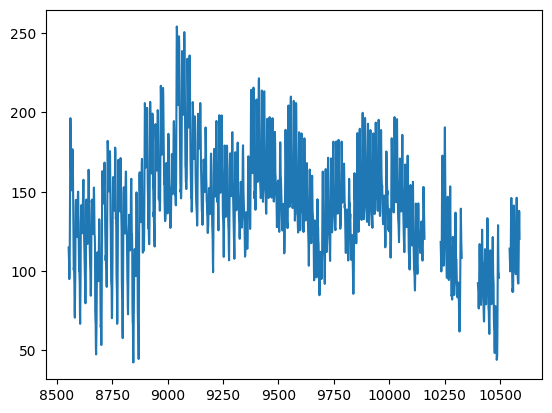

In [82]:
plt.plot(data_merge['predicted_spot_price'])